## Complete Feature Engineering and Model Training

### **Data Preprocessing**

In [1]:
# Importing required libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('dataset/Visa.csv')
df.head()

,case_id,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status
0,EZYV01,Asia,High School,N,N,14513,2007,West,592.2029,Hour,Y,Denied
1,EZYV02,Asia,Master's,Y,N,2412,2002,Northeast,83425.6500,Year,Y,Certified
2,EZYV03,Asia,Bachelor's,N,Y,44444,2008,West,122996.8600,Year,Y,Denied
3,EZYV04,Asia,Bachelor's,N,N,98,1897,West,83434.0300,Year,Y,Denied
4,EZYV05,Africa,Master's,Y,N,1082,2005,South,149907.3900,Year,Y,Certified


In [3]:
df.shape

(25480, 12)

In [4]:
# Checking for null values

df.isnull().sum()

case_id                  0
continent                0
education_of_employee    0
has_job_experience       0
requires_job_training    0
no_of_employees          0
yr_of_estab              0
region_of_employment     0
prevailing_wage          0
unit_of_wage             0
full_time_position       0
case_status              0
dtype: int64

In [5]:
# Checking for duplicates

df.duplicated().sum()

0

In [6]:
# Removing case_id column as it is not required for Model Training

df.drop('case_id', inplace = True, axis = 1)

### **Feature Engineering**

#### Feature Extraction

In [7]:
df.head(3)

,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status
0,Asia,High School,N,N,14513,2007,West,592.2029,Hour,Y,Denied
1,Asia,Master's,Y,N,2412,2002,Northeast,83425.6500,Year,Y,Certified
2,Asia,Bachelor's,N,Y,44444,2008,West,122996.8600,Year,Y,Denied


We will replace `year of establishment` with the `age of the company`, which is calculated as the difference between the current year and the year of establishment. This will help in understanding how long the company has been in operation, which can be a significant factor in visa approval.

In [8]:
from datetime import date

todays_date = date.today()
current_year = todays_date.year

print(current_year)

2025


In [9]:
# Subtract current year with year of estab to get company's age
df['company_age'] = current_year - df['yr_of_estab']

# Dropping the yr_or_estab column
df.drop('yr_of_estab', inplace = True, axis = 1) 

In [10]:
df.head()

,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status,company_age
0,Asia,High School,N,N,14513,West,592.2029,Hour,Y,Denied,18
1,Asia,Master's,Y,N,2412,Northeast,83425.6500,Year,Y,Certified,23
2,Asia,Bachelor's,N,Y,44444,West,122996.8600,Year,Y,Denied,17
3,Asia,Bachelor's,N,N,98,West,83434.0300,Year,Y,Denied,128
4,Africa,Master's,Y,N,1082,South,149907.3900,Year,Y,Certified,20


#### Types of Features

In [11]:
numerical_features = [feature for feature in df.columns if df[feature].dtype != 'O']
print('Num of Numerical Features :', len(numerical_features))

categorical_features = [feature for feature in df.columns if df[feature].dtype == 'O']
print('Num of Categorical Features :', len(categorical_features))

discrete_features=[feature for feature in numerical_features if len(df[feature].unique()) <= 25]
print('Num of Discrete Features :',len(discrete_features))

continuous_features = [feature for feature in numerical_features if feature not in discrete_features]
print('Num of Continuous Features :',len(continuous_features))

Num of Numerical Features : 3
Num of Categorical Features : 8
Num of Discrete Features : 0
Num of Continuous Features : 3


#### Dependent and Independent Features

In [12]:
X = df.drop('case_status', axis = 1)
Y = df['case_status']

In [13]:
Y.head()

0       Denied
1    Certified
2       Denied
3       Denied
4    Certified
Name: case_status, dtype: object

In [14]:
# Encoding the target column

Y = np.where(Y == 'Denied', 0, 1)

#### Feature Transformation

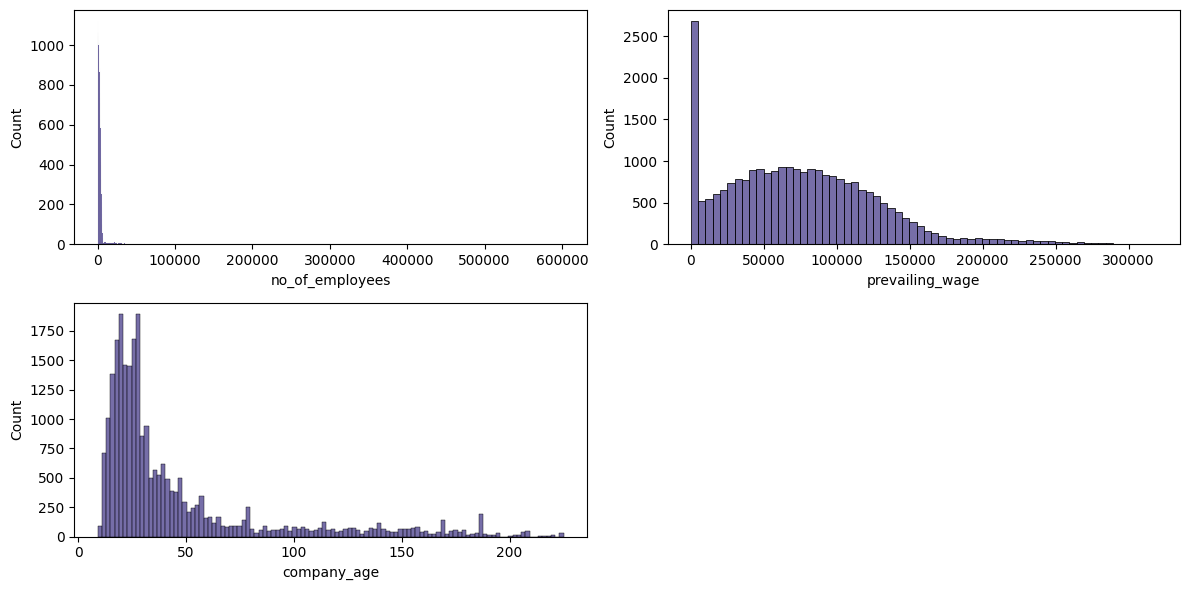

In [15]:
# Distribution of numerical data before scaling

plt.figure(figsize = (12, 6))
for i, col in enumerate(['no_of_employees', 'prevailing_wage', 'company_age']):
    plt.subplot(2, 2, i+1)
    sns.histplot(x=X[col], color = 'darkslateblue')
    plt.xlabel(col)
    plt.tight_layout()

- No of employees and Copmany age column is skewed

- Apply a power transformer featurewise to make data more Normally Distributed.

`Power transforms` are a family of parametric, monotonic transformations that are applied to make data more Gaussian-like. This is useful for modeling issues related to heteroscedasticity (non-constant variance), or other situations where normality is desired.

Currently, PowerTransformer supports the `Box-Cox transform` and the `Yeo-Johnson transform`.

**What is Skewness ?**

`Skewness` refers to a distortion or asymmetry that deviates from the symmetrical bell curve, or normal distribution, in a set of data. If the curve is shifted to the left or to the right, it is said to be skewed. Skewness can be quantified as a representation of the extent to which a given distribution varies from a normal distribution. A normal distribution has a skew of zero

In [16]:
# Checking skewness

X[continuous_features].skew(axis = 0, skipna = True)

no_of_employees    12.265260
prevailing_wage     0.755776
company_age         2.037301
dtype: float64

Here company_age, no_of_employees are positively skewed, so we will apply a power transformer to these features.

#### Applying Power Transformer to check if it can reduces the outliers


In [17]:
from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer(method = 'yeo-johnson')
transform_features = ['company_age', 'no_of_employees']

X_copy = pt.fit_transform(X[transform_features])


In [18]:
X_copy = pd.DataFrame(X_copy, columns = transform_features)

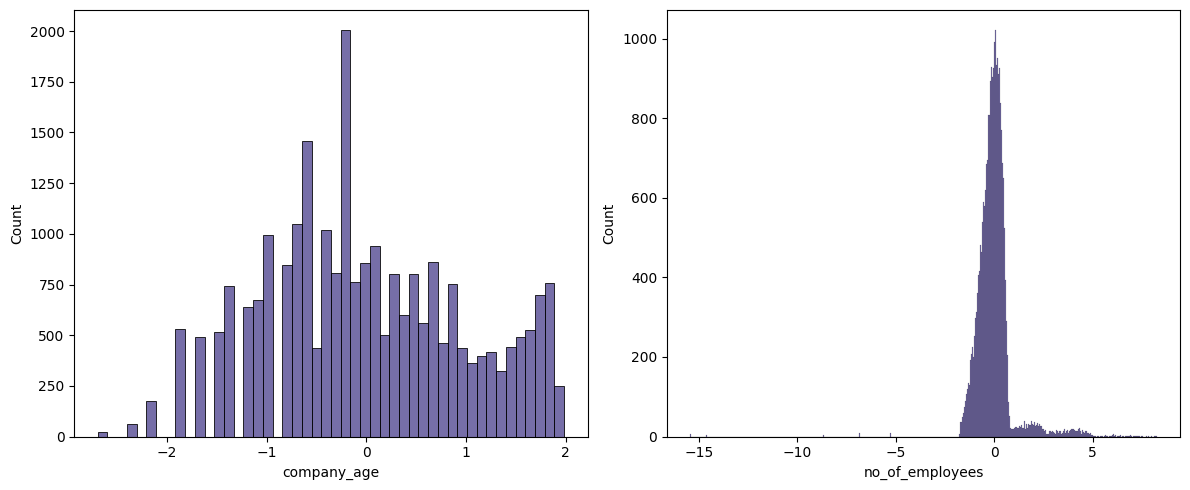

In [19]:
plt.figure(figsize = (12, 5))
for i, col in enumerate(transform_features):
    plt.subplot(1, 2, i+1)
    sns.histplot(x = X_copy[col], color ='darkslateblue')
    plt.xlabel(col)
    plt.tight_layout()

In [20]:
# Checking skewness

X_copy.skew(axis = 0, skipna = True)

company_age        0.112260
no_of_employees    0.399339
dtype: float64

- Here Yeo-Johnson is used and it supports both positive or negative data for transformation.

- So Power Transformer with yeo-johnson can be used.

### **Feature Encoding and Feature Scaling**

**One Hot Encoding for Columns which had lesser unique values and not ordinal**

- One hot encoding is a process by which categorical variables are converted into a form that could be provided to ML algorithms to do a better job in prediction.

**Ordinal Encoding for Columns which has many unique categories**
 
- Ordinal encoding is used here as label encoder is supported for column transformer.

- Ordinal encoding is used for Ordinal Variable. An ordinal variable is a categorical variable with a natural, ranked order between categories.

**Standard Scaler**

- Standardize features by removing the mean and scaling to unit variance.

- Used when your numerical data is roughly normally distributed already.

**Power Transformer**

- Power transforms are a technique for transforming numerical input or output variables to have a Gaussian or more-Gaussian-like probability distribution.

- Used when numerical data is highly skewed or has non-normal distributions.


In [21]:
numerical_features = [feature for feature in df.columns if df[feature].dtype != 'O']
print('Numerical Features :', numerical_features)

Numerical Features : ['no_of_employees', 'prevailing_wage', 'company_age']


In [22]:
# Preprocessing using Column Transformer

# Ordinal Encoding for Columns which has many unique categories
ordinal_columns = ['has_job_experience','requires_job_training','full_time_position','education_of_employee']
# One Hot Encoding for Columns which had lesser unique values and not ordinal
one_hot_columns = ['continent','unit_of_wage','region_of_employment']
# Transform columns that are highly skewed using Power Transformer
transform_columns = ['no_of_employees','company_age']

from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

standard_scaler = StandardScaler()
one_hot_encoder = OneHotEncoder()
ordinal_encoder = OrdinalEncoder()

transform_pipeline = Pipeline(steps = [
    ('transformer', PowerTransformer(method = 'yeo-johnson'))
])

preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder", one_hot_encoder, one_hot_columns), # One Hot Encoding to columns with fewer unique values
        ("OrdinalEncoder", ordinal_encoder, ordinal_columns), # Ordinal Encoding to columns with many unique categories
        ("Transformer", transform_pipeline, transform_columns), # Power Transformer to highly skewed numerical features
        ("StandardScaler", standard_scaler, numerical_features), # Standard Scaler to all numerical features
    ]
)

In [23]:
X = preprocessor.fit_transform(X)

In [24]:
X

array([[ 0.        ,  1.        ,  0.        , ...,  0.38666657,
        -1.39853722, -0.65122993],
       [ 0.        ,  1.        ,  0.        , ..., -0.14228155,
         0.1698353 , -0.53321103],
       [ 0.        ,  1.        ,  0.        , ...,  1.69498375,
         0.91907852, -0.6748337 ],
       ...,
       [ 0.        ,  1.        ,  0.        , ..., -0.19871259,
         1.36027953,  1.63833662],
       [ 0.        ,  1.        ,  0.        , ..., -0.16387483,
         0.22150859,  2.18122353],
       [ 0.        ,  1.        ,  0.        , ..., -0.10805575,
        -0.06776315,  0.45814768]])

### **Resampling** 

In [26]:
from imblearn.combine import SMOTEENN, SMOTETomek

# Resampling the minority class
smote = SMOTEENN(random_state = 42, sampling_strategy = 'minority')

X_res, Y_res = smote.fit_resample(X, Y)

### **Train Test Split**

In [28]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X_res, Y_res, random_state = 42, test_size = 0.2)
print(X_train.shape, Y_train.shape)

(13629, 24) (13629,)


### **Model Training**

In [29]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, \
    precision_score, recall_score, f1_score, roc_auc_score, roc_curve 

In [30]:
# Function to evaluate classification models

def evaluate_classification(true, predicted):
    accuracy = accuracy_score(true, predicted)
    f1 = f1_score(true, predicted)
    precision = precision_score(true, predicted)
    recall = recall_score(true, predicted)
    roc_auc = roc_auc_score(true, predicted)

    return accuracy, f1, precision, recall, roc_auc

In [31]:
models = {
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Logistic Regression": LogisticRegression(),
    "K-Neighbors Classifier": KNeighborsClassifier(),
    "XGBClassifier": XGBClassifier(), 
    "CatBoosting Classifier": CatBoostClassifier(verbose = False),
    "Support Vector Classifier": SVC(),
    "AdaBoost Classifier": AdaBoostClassifier()
}

In [34]:
# Function to evaluate models and return report

def evaluate_models(X, Y, models):
    # Separate dataset into train and test
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

    models_list = []
    accuracy_list = []
    auc = []

    for i in range(len(list(models))):
        model = list(models.values())[i]
        # Training the model
        model.fit(X_train, Y_train)

        # Making predictions
        Y_train_pred = model.predict(X_train)
        Y_test_pred = model.predict(X_test)

        # Training set performance
        model_train_accuracy, model_train_f1, model_train_precision,\
        model_train_recall, model_train_rocauc_score = evaluate_classification(Y_train ,Y_train_pred)

        # Testing set performance
        model_test_accuracy, model_test_f1, model_test_precision,\
        model_test_recall, model_test_rocauc_score = evaluate_classification(Y_test, Y_test_pred)

        print(list(models.keys())[i])
        models_list.append(list(models.keys())[i])

        print('Model performance for Training set')
        print("- Accuracy: {:.4f}".format(model_train_accuracy))
        print('- F1 score: {:.4f}'.format(model_train_f1)) 
        print('- Precision: {:.4f}'.format(model_train_precision))
        print('- Recall: {:.4f}'.format(model_train_recall))
        print('- Roc Auc Score: {:.4f}'.format(model_train_rocauc_score))

        print('----------------------------------')

        print('Model performance for Test set')
        print('- Accuracy: {:.4f}'.format(model_test_accuracy))
        accuracy_list.append(model_test_accuracy)
        print('- F1 score: {:.4f}'.format(model_test_f1))
        print('- Precision: {:.4f}'.format(model_test_precision))
        print('- Recall: {:.4f}'.format(model_test_recall))
        print('- Roc Auc Score: {:.4f}'.format(model_test_rocauc_score))
        auc.append(model_test_rocauc_score)
        print('=' * 35)
        print('\n')

    # Generating report in descending order of accuracy
    report = pd.DataFrame(list(zip(models_list, accuracy_list)), columns = ['Model Name', 'Accuracy']).sort_values(by = ['Accuracy'], ascending = False)
    return report



In [35]:
model_report = evaluate_models(X = X_res, Y = Y_res, models = models)

Random Forest
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.9484
- F1 score: 0.9438
- Precision: 0.9480
- Recall: 0.9396
- Roc Auc Score: 0.9477


Decision Tree
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.9161
- F1 score: 0.9090
- Precision: 0.9096
- Recall: 0.9085
- Roc Auc Score: 0.9155


Gradient Boosting
Model performance for Training set
- Accuracy: 0.8881
- F1 score: 0.8800
- Precision: 0.8697
- Recall: 0.8906
- Roc Auc Score: 0.8883
----------------------------------
Model performance for Test set
- Accuracy: 0.8823
- F1 score: 0.8750
- Precision: 0.8586
- Recall: 0.8919
- Roc Auc Score: 0.8830


Logistic Regression
Model performance for Training 

In [36]:
model_report

,Model Name,Accuracy
0,Random Forest,0.948357
5,XGBClassifier,0.929577
6,CatBoosting Classifier,0.926937
4,K-Neighbors Classifier,0.926350
1,Decision Tree,0.916080
2,Gradient Boosting,0.882336
7,Support Vector Classifier,0.860915
8,AdaBoost Classifier,0.855340
3,Logistic Regression,0.736796


**As Random Forest has the highest accuracy, we will use it for Hyperparameter Tuning**

#### **Hyperparameter Tuning**

In [37]:
# Few parameters for Hyperparameter Tuning

rf_params = {
    "max_depth": [10, 12, None, 15, 20],
    "max_features": ['sqrt', 'log2', None],
    "n_estimators": [10, 50, 100, 200]
}

xgboost_params = {
    'max_depth': range(3, 10, 2),
    'min_child_weight': range(1, 6, 2)
}

knn_params = {
    "algorithm": ['auto', 'ball_tree', 'kd_tree','brute'],
    "weights": ['uniform', 'distance'],
    "n_neighbors": [3, 4, 5, 7, 9],
}

In [38]:
randomcv_models = [
    ('XGBoost', XGBClassifier(), xgboost_params),
    ("RF", RandomForestClassifier(), rf_params),
    ("KNN", KNeighborsClassifier(), knn_params)
]

In [39]:
# Function for Hyperparameter tuning and report generation

from sklearn.model_selection import RandomizedSearchCV

model_param = {}

for name, model, params in randomcv_models:
    random_cv = RandomizedSearchCV(estimator = model, 
                                  param_distributions = params,
                                  n_iter = 100,
                                  cv = 3, 
                                  verbose = 2,
                                  n_jobs = 1) 
    random_cv.fit(X_res, Y_res)
    model_param[name] = random_cv.best_params_

for model_name in model_param:
    print(f"---------------- Best Params for {model_name} -------------------")
    print(model_param[model_name])

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END ....................max_depth=3, min_child_weight=1; total time=   0.1s
[CV] END ....................max_depth=3, min_child_weight=1; total time=   0.1s
[CV] END ....................max_depth=3, min_child_weight=1; total time=   0.1s
[CV] END ....................max_depth=3, min_child_weight=3; total time=   0.1s
[CV] END ....................max_depth=3, min_child_weight=3; total time=   0.1s
[CV] END ....................max_depth=3, min_child_weight=3; total time=   0.1s
[CV] END ....................max_depth=3, min_child_weight=5; total time=   0.1s
[CV] END ....................max_depth=3, min_child_weight=5; total time=   0.1s
[CV] END ....................max_depth=3, min_child_weight=5; total time=   0.1s
[CV] END ....................max_depth=5, min_child_weight=1; total time=   0.1s
[CV] END ....................max_depth=5, min_child_weight=1; total time=   0.1s
[CV] END ....................max_depth=5, min_ch

In [40]:
model_param

{'XGBoost': {'min_child_weight': 1, 'max_depth': 9},
 'RF': {'n_estimators': 100, 'max_features': 'log2', 'max_depth': None},
 'KNN': {'weights': 'distance', 'n_neighbors': 4, 'algorithm': 'auto'}}

In [41]:
# Retraining the models with the best parameters

from sklearn.metrics import roc_auc_score, roc_curve

best_models = {
    "Random Forest Classifier": RandomForestClassifier(**model_param['RF']),
    "KNeighborsClassifier": KNeighborsClassifier(**model_param['KNN']),
    "XGBClassifier": XGBClassifier(**model_param['XGBoost'],n_jobs = -1),
}
report = evaluate_models(X = X_res, Y = Y_res, models = best_models)

Random Forest Classifier
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.9481
- F1 score: 0.9435
- Precision: 0.9469
- Recall: 0.9402
- Roc Auc Score: 0.9475


KNeighborsClassifier
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.9645
- F1 score: 0.9611
- Precision: 0.9727
- Recall: 0.9498
- Roc Auc Score: 0.9634


XGBClassifier
Model performance for Training set
- Accuracy: 0.9989
- F1 score: 0.9988
- Precision: 0.9998
- Recall: 0.9978
- Roc Auc Score: 0.9988
----------------------------------
Model performance for Test set
- Accuracy: 0.9425
- F1 score: 0.9379
- Precision: 0.9349
- Recall: 0.9409
- Roc Auc Score: 0.9424




In [43]:
report

,Model Name,Accuracy
1,KNeighborsClassifier,0.964495
0,Random Forest Classifier,0.948063
2,XGBClassifier,0.942488


In [44]:
best_model = KNeighborsClassifier(**model_param['KNN'])
best_model = best_model.fit(X_train, Y_train)

Y_pred = best_model.predict(X_test)
score = accuracy_score(Y_test, Y_pred)
cls_report = classification_report(Y_test, Y_pred)

print("FINAL MODEL 'KNN'")
print ("Accuracy Score value: {:.4f}".format(score))
print (cls_report)

FINAL MODEL 'KNN'
Accuracy Score value: 0.9645
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1835
           1       0.97      0.95      0.96      1573

    accuracy                           0.96      3408
   macro avg       0.97      0.96      0.96      3408
weighted avg       0.96      0.96      0.96      3408



#### **Confusion Matrix**

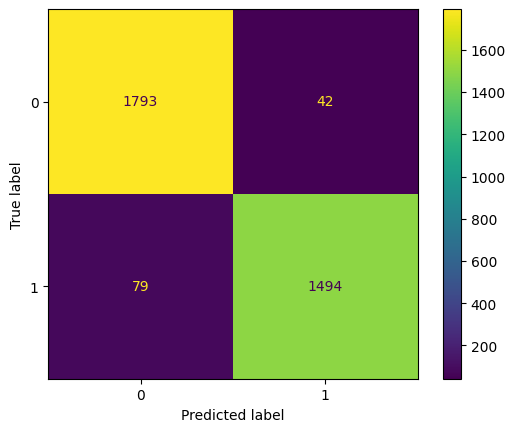

In [46]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(best_model, X_test, Y_test)